In [2]:
# Imports
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Custom functions
import dataload
import transform

In [2]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,             # Channel to be used
    'dur_epoch': 30,          # Time of window page [s]
    'n2_val': 3,              # N2 state coding value
    'window': 1,              # Length of window for spectrogram, in [s]
    'context': 1,             # Additional context so we can compute spectrum at the borders of the window, in [s]
    'mark_smooth': 1          # Number of samples to average at the center to get the segment central mark.
    # 'dur_min_ss': 0.3,      # Min SS duration [s]
    # 'dur_max_ss': 3.0       # Max SS duration [s]
}

In [3]:
# Read everything
signal_list = []
marks_list = []
states_list = []
for i in range(len(all_names)):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = dataload.read_eeg(path_edf_file, params['channel'])
    signal_list.append(signal)
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks = dataload.read_marks(path_marks_file, params['channel'])
    marks_list.append(marks)
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = dataload.read_states(path_states_file)
    states_list.append(states)    
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(signal_list), ' EEG signals have been read.')
print(len(marks_list), ' sleep spindle marks files have been read.')
print(len(states_list), ' state annotations files have been read.')
print('Sampling Frequency: ', fs, 'Hz')



11  EEG signals have been read.
11  sleep spindle marks files have been read.
11  state annotations files have been read.
Sampling Frequency:  200 Hz


In [4]:
# Get appropiate segments
start = time.time()
ind_list = []
#for ind in range(len(signal_list)):
for ind in range(1):
    signal = signal_list[ind]
    states = states_list[ind]
    marks = marks_list[ind]
    marks = transform.inter2seq(marks, 0, len(signal) - 1)
    n_epoch = len(states)
    # Find n2 epochs segments
    n2_epochs = (states == params['n2_val']).astype(int)
    n2_epochs = transform.seq2inter(n2_epochs)
    
    # List for this individual, n2 epochs only
    # For now, drop epoch if it is at the very beginning or at the very end of a register, because we can't have context
    # And if it is at the end, we can have a different length, which is beyond the scope for now
    n2_eeg_seg_list = []
    n2_mark_list = []
    n2_epoch_id_list = []
    n2_seg_id_list = []
    # Get window left and right number of samples
    win_side = int((params['window']/2 + params['context']) * params['fs'])
    for seg in range(len(n2_epochs)):  # For each N2 segment
            for epoch in range(n2_epochs[seg, 0], n2_epochs[seg, 1] + 1):  # For each epoch in that segment
                if epoch == 0 or epoch == n_epoch - 1:
                    # If this is the first or the last epoch, drop it
                    continue
                # Since this epoch is useful, we have to iterate over all its samples
                sample_start = epoch * params['dur_epoch'] * params['fs']
                sample_end = (epoch + 1) * params['dur_epoch'] * params['fs']
                for sample in range(sample_start,sample_end):               
                    # Save the easy stuff
                    n2_epoch_id_list.append(epoch)
                    n2_seg_id_list.append(seg) 
                    # Now get the window
                    win_start = sample - win_side
                    win_end = sample + win_side
                    # Get eeg
                    n2_eeg_seg_list.append(signal[win_start:win_end])
                    # Get mark, with an optional smoothing 
                    smooth_start = sample - int(np.floor(params['mark_smooth']/2))
                    smooth_end = smooth_start + params['mark_smooth']
                    smooth_mark = np.mean(marks[smooth_start:smooth_end])
                    n2_mark_list.append(smooth_mark)
    ind_list.append({'EEG_SEG': np.asarray(n2_eeg_seg_list),
                    'MARK': np.array(n2_mark_list),
                    'ID_EPOCH': np.array(n2_epoch_id_list),
                    'ID_SEG': np.array(n2_seg_id_list),
                    'ID_IND': ind})
    print('Subject '+str(ind)+' Ready, Time: ' + str(time.time() - start))
print('Segmentation ready')

Subject 0 Ready, Time: 15.500129222869873
Segmentation ready


<class 'numpy.ndarray'>
{'ID_SEG': array([0, 0, 0, ..., 7, 7, 7]), 'MARK': array([1., 1., 1., ..., 0., 0., 0.]), 'ID_IND': 0, 'EEG_SEG': array([[ -6.41519799,  -0.91645686,   4.72327764, ..., -76.91187915,
        -77.19386587, -75.78393225],
       [ -0.91645686,   4.72327764,   9.79903868, ..., -77.19386587,
        -75.78393225, -71.97711147],
       [  4.72327764,   9.79903868,  13.04188602, ..., -75.78393225,
        -71.97711147, -66.19638361],
       ...,
       [  0.49347677,   5.14625772,  10.36301213, ...,   9.09407187,
          8.10711833,   8.53009842],
       [  5.14625772,  10.36301213,  13.04188602, ...,   8.10711833,
          8.53009842,   9.51705196],
       [ 10.36301213,  13.04188602,  13.74685283, ...,   8.53009842,
          9.51705196,  10.64499886]]), 'ID_EPOCH': array([ 28,  28,  28, ..., 910, 910, 910])}
<class 'numpy.ndarray'>


<function matplotlib.pyplot.show(*args, **kw)>

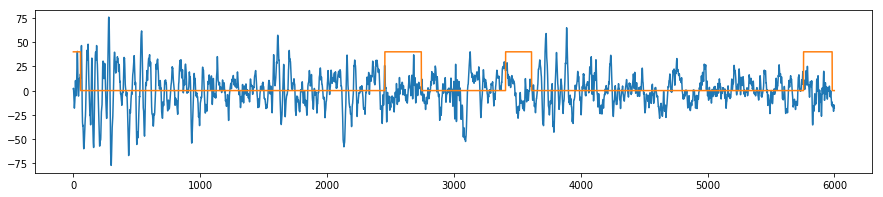

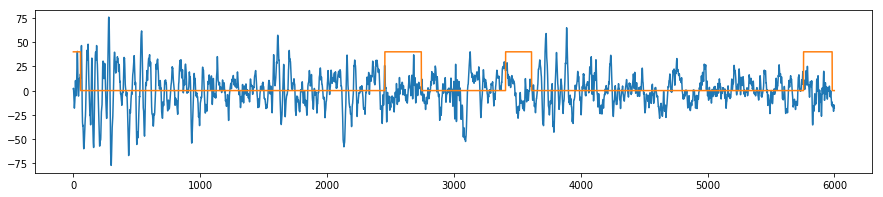

In [93]:
# Inspect segment
#print(ind_list[0]['ID_IND'])
#print(ind_list[0]['ID_SEG'].shape)
#print(ind_list[0]['ID_EPOCH'].shape)
#unique, counts = np.unique(ind_list[0]['ID_EPOCH'], return_counts=True)
#print(unique)
#print(len(unique))
#print(counts)
#print(ind_list[0]['MARK'].shape)
#print(ind_list[0]['MARK'][0:100])

#print(len(ind_list[0]['EEG_SEG']))
print(type(ind_list[0]['EEG_SEG']))
plt.figure(figsize=(15, 3))
plt.plot(ind_list[0]['EEG_SEG'][0:6000,300])
plt.plot(40*ind_list[0]['MARK'][0:6000])
plt.show
print(ind_list[0])

# This plot should be equal
print(type(ind_list[0]['EEG_SEG']))
plt.figure(figsize=(15, 3))
offset = 28*200*30
plt.plot(signal[(0+offset):(6000+offset)])
plt.plot(40*marks[(0+offset):(6000+offset)])
plt.show



In [5]:
np.savetxt('dummy_eeg.csv', ind_list[0]['EEG_SEG'][0:6000,:], delimiter=' ') # 91MB
np.savetxt('dummy_mark.csv', ind_list[0]['MARK'][0:6000], delimiter=' ') # 159kb

# Normalization by-subject
# have in mind sklearn.preprocessing.robust_scale

In [ ]:
# Save csv


In [95]:
# Get CWT of each segment. Keep only central window